# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.348900,True,2.724803
1,-1.416028,False,-5.297047
2,1.339480,True,7.831478
3,0.486306,True,6.517949
4,-1.931233,False,-4.004848
...,...,...,...
995,-0.574632,True,4.193243
996,0.650107,True,7.345007
997,0.258377,False,-0.218013
998,-1.247673,False,-2.829876


<AxesSubplot:xlabel='v0'>

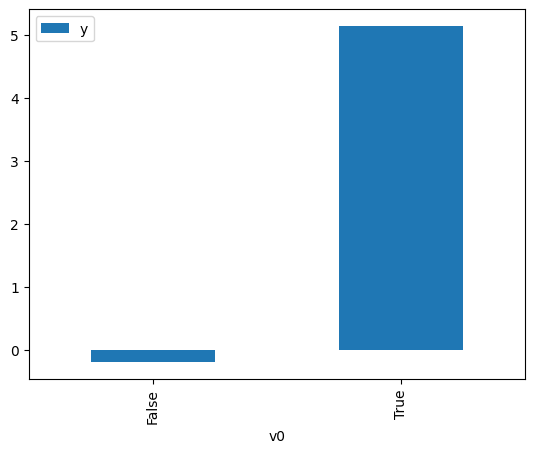

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

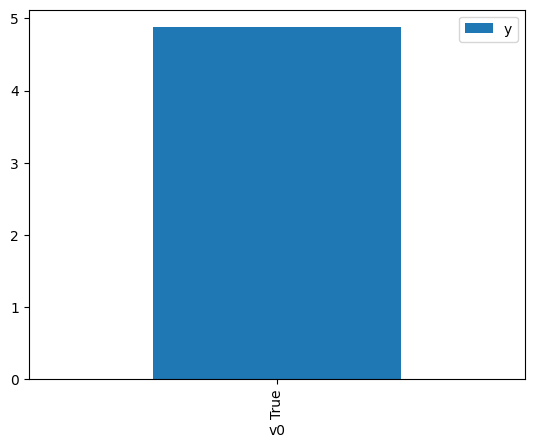

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.036776,False,-2.975269,0.956969,1.044966
1,-0.246528,False,-0.338273,0.577322,1.732135
2,0.899619,False,3.074898,0.186267,5.368644
3,-0.259573,False,0.107464,0.582275,1.717401
4,0.488808,False,2.031841,0.302755,3.303004
...,...,...,...,...,...
995,-1.264433,False,-3.040332,0.869684,1.149842
996,-0.561551,False,-2.073441,0.690562,1.448096
997,-0.071389,False,-1.091597,0.509709,1.961904
998,-0.712630,False,-0.358626,0.738502,1.354092


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.647848,True,4.059408,0.281459,3.552921
1,0.909232,True,6.971657,0.815994,1.225500
2,0.079688,True,5.805927,0.548995,1.821511
3,0.755315,True,6.293804,0.777224,1.286631
4,1.834860,True,10.353869,0.949406,1.053290
...,...,...,...,...,...
995,0.054286,True,6.989439,0.539175,1.854686
996,1.730881,True,9.123788,0.941031,1.062665
997,-0.876869,True,4.300003,0.215149,4.647938
998,-1.926717,True,1.270687,0.050675,19.733717


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                          1.215e+04
Date:                Tue, 06 Sep 2022   Prob (F-statistic):                        0.00
Time:                        08:07:18   Log-Likelihood:                         -1437.9
No. Observations:                1000   AIC:                                      2880.
Df Residuals:                     998   BIC:                                      2890.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4902      0.035     71.513      0.000       2.422       2.559
x2             4.9706      0.049    102.231      0.000       4.875       5.066
==============================================================================
Omnibus:                        0.419   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.811   Jarque-Bera (JB):                0.508
Skew:                          -0.020   Prob(JB):                        0.776
Kurtosis:                       2.897   Cond. No.                         1.68
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""